# Kernel Kernel Demo

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from GPy import likelihoods
from GPy.core.parameterization.priors import Gaussian
from GPy.kern import RBFDistanceBuilderKernelKernel

from src.autoks.core.active_set import ActiveSet
from src.autoks.core.gp_model import GPModel
from src.autoks.core.grammar import BomsGrammar
from src.autoks.distance.distance import FrobeniusDistanceBuilder

## Create kernels and data

In [2]:
# SE, RQ, PER, SE + PER
grammar = BomsGrammar(base_kernel_names=['SE', 'RQ', 'PER'])
grammar.build(1)
se, rq, per = grammar.base_kernels
se_plus_per = se + per

data_x = np.linspace(0., 1., 500)
data_x = data_x[:, None]
data_y = data_x ** 2

## Define helper functions

In [48]:
def covariances_to_gp_models(covariances):
    lik = likelihoods.Gaussian()
    gp_models = [GPModel(cov, lik) for cov in covariances]
    return gp_models

def create_active_set(covariances, max_n_models):
    active_models = ActiveSet(max_n_models)
    active_models.update(covariances_to_gp_models(covariances))
    return active_models

def create_distance_builder(active_models, initial_model_indices, noise_prior=None, num_samples=20, 
                            max_num_hyperparameters=40):
    if noise_prior is None:
        noise_prior = Gaussian(np.log(0.01), 1)

    builder = FrobeniusDistanceBuilder(noise_prior, num_samples, max_num_hyperparameters, active_models.max_n_models,
                                       active_models, initial_model_indices, data_X=data_x)
    
    return builder

def create_kernel_kernel(builder, active_models):
    return RBFDistanceBuilderKernelKernel(builder, n_models=len(active_models))

def display_frob_kernel(builder, active_models):
    frob_kernel_matrix = builder.get_kernel(len(active_models))
    with np.printoptions(precision=5, suppress=True):
        print('Frobenius distance: \n', frob_kernel_matrix)
    
    plt.imshow(frob_kernel_matrix, cmap='Blues')

def display_kernel_kernel(kernel_kernel, initial_model_indices):
    x_pred = np.array(initial_model_indices)
    x_pred = x_pred[:, None]
    kernel_kernel_matrix = kernel_kernel.K(x_pred)
    plt.imshow(kernel_kernel_matrix, cmap='Blues')
    with np.printoptions(precision=5, suppress=True):
        print("Kernel kernel: \n",kernel_kernel_matrix)

In [51]:
max_num_kernels = 1000
covariances_init = [se, rq, per, se_plus_per]
active_models = create_active_set(covariances_init, max_num_kernels)

initial_model_indices = list(range(len(active_models)))
builder = create_distance_builder(active_models, initial_model_indices)
builder.compute_distance(active_models, initial_model_indices, initial_model_indices)

kernel_kernel = create_kernel_kernel(builder, active_models)

Frobenius distance: 
 [[0.      0.00259 0.0228  2.54612]
 [0.00259 0.      0.02175 2.51043]
 [0.0228  0.02175 0.      2.4649 ]
 [2.54612 2.51043 2.4649  0.     ]]


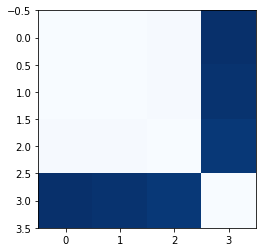

In [52]:
display_frob_kernel(builder, active_models)

Kernel Kernel: 
 [[1.      1.      0.99974 0.03911]
 [1.      1.      0.99976 0.0428 ]
 [0.99974 0.99976 1.      0.04794]
 [0.03911 0.0428  0.04794 1.     ]]


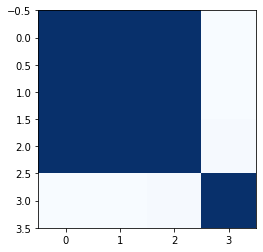

In [53]:
display_kernel_kernel(kernel_kernel, initial_model_indices)